In [2]:
!pip install torch
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from pathlib import Path
import os
import pandas as pd
import librosa
import re
import matplotlib.pyplot as plt
import numpy as np
#from scipy.signal import butter, sosfiltfilt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import cv2

## tqdm for loading bars
from tqdm.notebook import tqdm

import tensorflow as tf

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## Torchvision
import torchvision
from torchvision import transforms
from torchvision import models

from torchsummary import summary

In [4]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#ensure reproducibility on gpu

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = "/content/drive/MyDrive/Colab Notebooks/aiti_project/chromagrams/"

image_names = os.listdir(path)

n_chroma = len(image_names)
print(n_chroma)

5287


In [7]:
BATCH_SIZE = 32 #64 #128 #32 #PARAM

In [8]:
y_dim = 12
x_dim = 474

steps = n_chroma//BATCH_SIZE

generator that is used instead of a dataloader in order to avoid exceeding the ram capacity

In [9]:
# Make this an infinite generator
def gen(img_names):

  while True:
    i = 0
    images = np.zeros((BATCH_SIZE,y_dim,x_dim), dtype=np.float64)

    while i < len(img_names):
      complete_path = path + img_names[i]

      images[i%BATCH_SIZE,:,:] = cv2.imread(complete_path, cv2.IMREAD_GRAYSCALE)[:y_dim,:x_dim]/255
      i += 1
      if i%BATCH_SIZE == 0:
        images = images.reshape(BATCH_SIZE, y_dim, x_dim, 1)
        yield (images)
        images = np.zeros((BATCH_SIZE,y_dim,x_dim))

In [10]:
class IterDataset(data.IterableDataset):
    def __init__(self, generator):
        self.generator = generator

    def __iter__(self):
        return self.generator()

In [11]:
images_gen = gen(image_names)

transformation function and data loader

In [12]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                transforms.RandomAffine(degrees=0, translate=(0.1,0)),
                                transforms.RandomErasing(p=0.3, scale=(0.02, 0.03), ratio=(0.2,0.3), value=0.6, inplace=False),  
                                #transforms.RandomErasing(p=0.4, scale=(0.02, 0.1), ratio=(0.02,0.05), value=0.9, inplace=False)
                               ])

In [13]:
train_generator = IterDataset(images_gen) 

train_dataloader = torch.utils.data.DataLoader(train_generator)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
#creds resnet https://github.com/JayPatwardhan/ResNet-PyTorch/blob/master/ResNet/ResNet.py
import torch
import torch.nn as  nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x

class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)
  
        
def ResNet50(num_classes=1000, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

def ResNet101(num_classes=1000, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes=1000, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)

In [16]:
class SimCLRModel(nn.Module):
    def __init__(self):
      super(SimCLRModel, self).__init__()

      #self.resnet = ResNet152()
      #torch default resnet50
      #self.resnet = torchvision.models.resnet50(weights=None)  #maybe we could use some already existing weights
      
      #torch default resnet18
      self.resnet = torchvision.models.resnet18(weights=None)
      
      #self.resnet = ResNet(models.resnet.Bottleneck, [3, 8, 36, 3], pretrained = False)    #if we want to use a 1d tensor, but it might be easier to just paste it three times onto a 3d tensor
      #self.avgpool = torch.nn.AvgPool2d()   #it flattens one dimension? if that's it we already have a 2d array
      self.fc1 = nn.Linear(1000, 256)   #not sure about 1000
      self.fc2 = nn.Linear(256, 128)
      self.fc3 = nn.Linear(128, 50)
      self.relu = nn.ReLU()

    def forward(self, x):
      x = self.resnet(x)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.fc3(x)
      return x

In [17]:
model = SimCLRModel()
model = model.to(device)

In [18]:
summary(model, (3, 12, 474))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 6, 237]           9,408
       BatchNorm2d-2           [-1, 64, 6, 237]             128
              ReLU-3           [-1, 64, 6, 237]               0
         MaxPool2d-4           [-1, 64, 3, 119]               0
            Conv2d-5           [-1, 64, 3, 119]          36,864
       BatchNorm2d-6           [-1, 64, 3, 119]             128
              ReLU-7           [-1, 64, 3, 119]               0
            Conv2d-8           [-1, 64, 3, 119]          36,864
       BatchNorm2d-9           [-1, 64, 3, 119]             128
             ReLU-10           [-1, 64, 3, 119]               0
       BasicBlock-11           [-1, 64, 3, 119]               0
           Conv2d-12           [-1, 64, 3, 119]          36,864
      BatchNorm2d-13           [-1, 64, 3, 119]             128
             ReLU-14           [-1, 64,

**Loss function**

In [19]:
negative_mask = np.ones((BATCH_SIZE, 2 * BATCH_SIZE), dtype=bool)
for i in range(BATCH_SIZE):
    negative_mask[i, i] = 0
    negative_mask[i, i + BATCH_SIZE] = 0
negative_mask = torch.from_numpy(negative_mask).to(device)

def loss_fn(xis, xjs, model, optimizer, criterion, temperature):
  optimizer.zero_grad()

  xis = xis.to(device)
  xjs = xjs.to(device)
  xis = xis.float()
  xjs = xjs.float()

  zis = model(xis)
  zjs = model(xjs)

  zis = torch.nn.functional.normalize(zis, p=2, dim=1)
  zjs = torch.nn.functional.normalize(zjs, p=2, dim=1)

  l_pos = torch.matmul(torch.unsqueeze(zis, 1), torch.unsqueeze(zis, 2))
  l_pos = torch.reshape(l_pos, (BATCH_SIZE, 1))
  l_pos = l_pos / temperature

  negatives = torch.cat([zjs, zis], axis=0)

  loss = 0

  for positives in [zis, zjs]:
    
      cosine_sim_2d = torch.nn.CosineSimilarity(dim=2, eps=1e-08)
      l_neg = cosine_sim_2d(torch.unsqueeze(positives, 1), torch.unsqueeze(negatives, 0))

      labels = torch.zeros(BATCH_SIZE, dtype=torch.int32).type(torch.LongTensor).to(device)

      l_neg = torch.masked_select(l_neg, negative_mask)
      l_neg = torch.reshape(l_neg, (BATCH_SIZE, -1))
      l_neg = l_neg / temperature

      logits = torch.cat([l_pos, l_neg], axis=1)
      loss += criterion(input=logits, target=labels)

  loss = loss / (2 * BATCH_SIZE)

  loss.backward()
  optimizer.step()

  return loss

**Training function**

In [20]:
def train_simclr(model, dataloader, optimizer, criterion,
                 temperature=0.1, epochs=3):
    step_wise_loss = []
    epoch_wise_loss = []

    for epoch in tqdm(range(epochs)):
        #for image_batch in dataloader:
        for i in tqdm(range(steps)):
            #print(i, "/", steps)
            image_batch = next(images_gen)
            a = transforms.Lambda(lambda x: torch.stack([transform(x_) for x_ in x]))(image_batch)
            b = transforms.Lambda(lambda x: torch.stack([transform(x_) for x_ in x]))(image_batch)

            loss = loss_fn(a, b, model, optimizer, criterion, temperature).item()
            step_wise_loss.append(loss)

        epoch_wise_loss.append(np.mean(step_wise_loss))    #does the mean make sense. find out in the next episode
        
        print("epoch: {} loss: {:.3f}".format(epoch + 1, np.mean(step_wise_loss)))

    return epoch_wise_loss, model

**Running of the training**

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 1 loss: 0.017


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 2 loss: 0.011


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 3 loss: 0.008


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 4 loss: 0.007


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 5 loss: 0.006


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 6 loss: 0.005


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 7 loss: 0.005


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 8 loss: 0.005


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 9 loss: 0.004


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 10 loss: 0.004


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 11 loss: 0.004


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 12 loss: 0.004


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 13 loss: 0.003


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 14 loss: 0.003


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 15 loss: 0.003


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 16 loss: 0.003


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 17 loss: 0.003


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 18 loss: 0.003


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 19 loss: 0.003


  0%|          | 0/165 [00:00<?, ?it/s]

epoch: 20 loss: 0.003


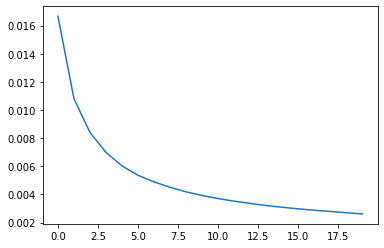

In [21]:
LEARNING_RATE = 1e-3

criterion = torch.nn.CrossEntropyLoss()

#decay_steps = 1000
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Adam with weight decay
optimizerW = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay = 1e-2)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizerW, T_max=100, eta_min=LEARNING_RATE//50) #t_max = max_epochs

epoch_wise_loss, model_trained  = train_simclr(model, train_dataloader, optimizer, criterion,
                 temperature=0.1, epochs=20)


plt.plot(epoch_wise_loss)
plt.show()

here we do the encoding on the test. Test is the set of the original images, without augmentation

In [22]:
transform_test = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambda x: x.repeat(3, 1, 1, 1))])

# empty numpy array, we want to append to an empty list basically
all_features = np.array([]).reshape((0,50))

for i in tqdm(range(steps)):
  batch = next(images_gen).reshape((BATCH_SIZE,y_dim,x_dim))
  test = transform_test(batch)
  test = test.permute((2, 0, 3, 1)).to(device).float()

  features = model(test)

  features = features.detach().cpu().numpy()

  all_features = np.concatenate((all_features, features))

print(all_features.shape)

  0%|          | 0/165 [00:00<?, ?it/s]

(5280, 50)


In [23]:
all_features

array([[-0.60626948,  0.26368672, -0.53522038, ...,  0.66951191,
         0.99075592,  1.26725686],
       [ 0.06317221,  0.73541886, -1.73513889, ...,  0.64002097,
        -0.00675425,  0.55459553],
       [ 0.40913305,  0.38777098, -2.71778774, ...,  1.19998729,
        -1.15054667, -0.82131284],
       ...,
       [ 1.76055098,  1.22218812,  0.54969704, ...,  0.94757915,
        -0.33765236, -0.10141464],
       [ 0.01774827, -1.41775513,  1.24013972, ...,  3.17542267,
        -3.0643332 ,  2.90752769],
       [ 1.57126904,  0.09434617, -0.90643024, ...,  2.89845109,
         2.83179736, -4.54206085]])

In [24]:
print(len(features))

32


**Clustering**

In [25]:
from sklearn.metrics import calinski_harabasz_score

#kmeneans clustering

cluster_number = range(2,240,2) #cluster number

distortions = []
silhouette_scores = []
calinski_harabasz_scores = []
for n in tqdm(cluster_number):
    estimator = KMeans(n_clusters = n, init='k-means++', n_init=10, max_iter=300)
    y = estimator.fit_predict(all_features)
    #metrics
    distortions.append(estimator.inertia_)
    silhouette_scores.append(silhouette_score(all_features,y))
    calinski_harabasz_scores.append(calinski_harabasz_score(all_features,y))

  0%|          | 0/119 [00:00<?, ?it/s]

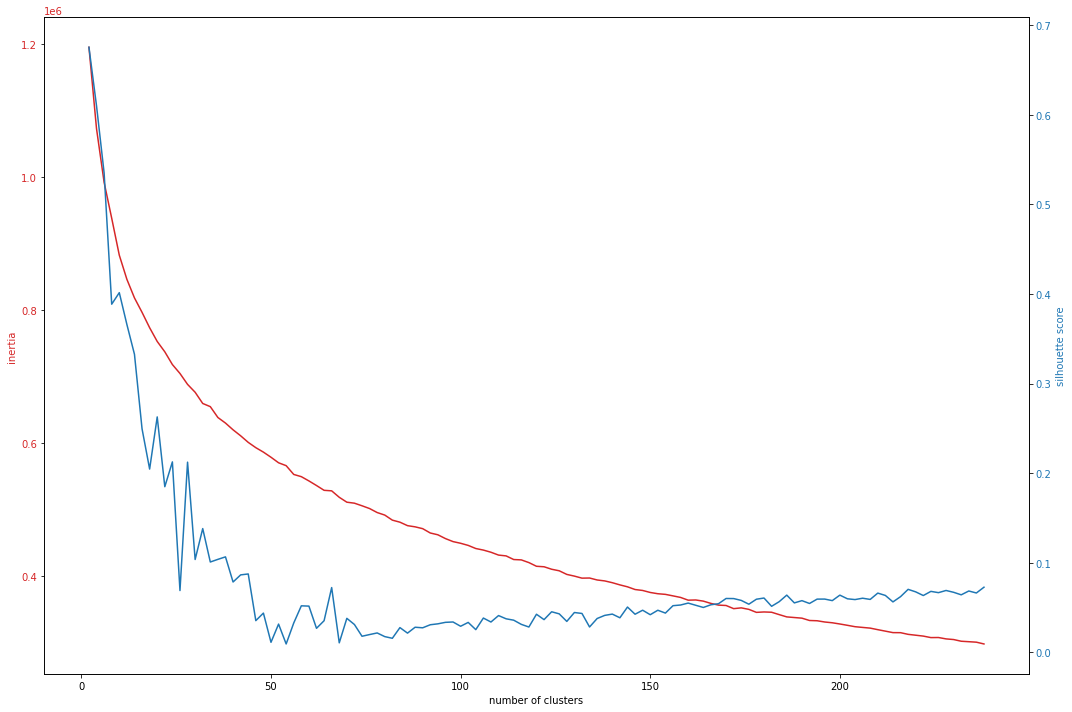

(5280, 50)


In [26]:
t = cluster_number
data1 = distortions
data2 = silhouette_scores #calinski_harabasz_scores 

fig, ax1 = plt.subplots(figsize = (15, 10))
          
color = 'tab:red'
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('inertia', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('silhouette score', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim(-0.03,1) # the axis for silhouette is [0,1]

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()
print(all_features.shape)

In [27]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

def plot_clusters(X, y, dim, points=None,
                  labels_prefix = 'cluster', 
                  points_name = 'centroids',
                  colors = cm.tab10, # a qualitative map 
                      # https://matplotlib.org/examples/color/colormaps_reference.html
#                   colors = ['brown', 'orange', 'olive', 
#                             'green', 'cyan', 'blue', 
#                             'purple', 'pink'],
#                   points_color = 'red'
                  points_color = cm.tab10(10), # by default the last of the map (to be improved)
                  dbscan = False):
    """
    Plot a two dimensional projection of an array of labelled points
    X:      array with at least two columns
    y:      vector of labels, length as number of rows in X
    dim:    the two columns to project, inside range of X columns, e.g. (0,1)
    points: additional points to plot as 'stars'
    labels_prefix: prefix to the labels for the legend ['cluster']
    points_name:   legend name for the additional points ['centroids']
    colors: a color map
    points_color: the color for the points
    """
    # plot the labelled (colored) dataset and the points
    labels = np.unique(y)
    for i in range(len(labels)):
        color = colors(i / len(labels)) # choose a color from the map
        plt.scatter(X[y==labels[i],dim[0]], 
                    X[y==labels[i],dim[1]], 
                    s=10, 
                    c = [color], # scatter requires a sequence of colors
                    marker='s', 
                    label=labels_prefix+str(labels[i]))
    if dbscan == False:
        plt.scatter(points[:,dim[0]], points[:,dim[1]], s=50, marker='*', c=[points_color], label=points_name)
    plt.legend()
    plt.grid()
    plt.show() 

**Kmeans**: Running kmeans with a fixed number of clusters. 

In [34]:
good_k = 100

estimator = KMeans(n_clusters = good_k, init='k-means++', n_init=10, max_iter=300,)
y = estimator.fit_predict(all_features)

In [35]:
print(len(all_features))

5280


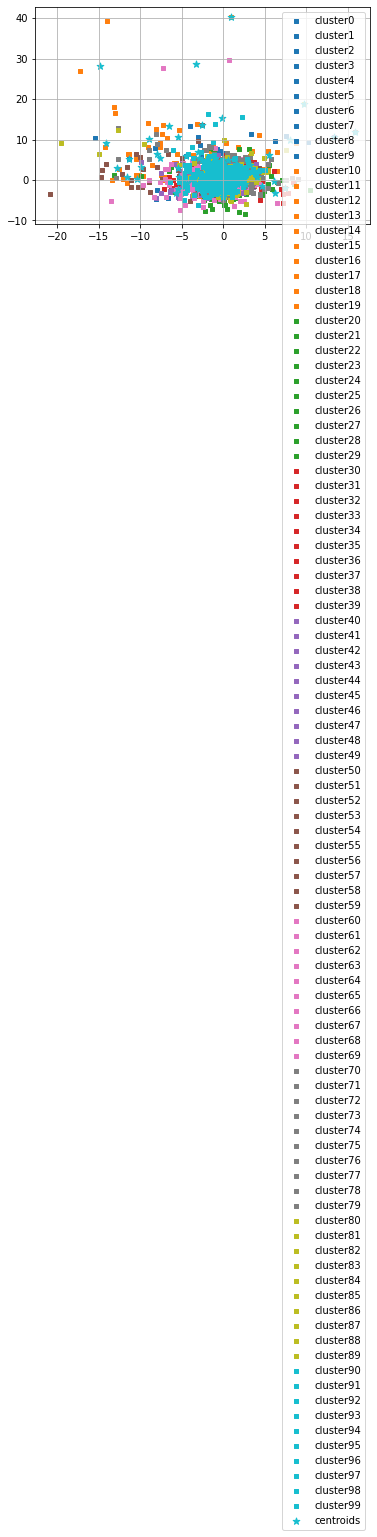

In [36]:
plot_clusters(all_features, y, dim= (0,1), points= estimator.cluster_centers_)

**DBSCAN** Clustering

In [37]:
from sklearn.cluster import DBSCAN

#definition of the dbscan model
db_model = DBSCAN(eps=0.05, min_samples=10) 
y_pred = db_model.fit_predict(all_features) #dbscan predictions

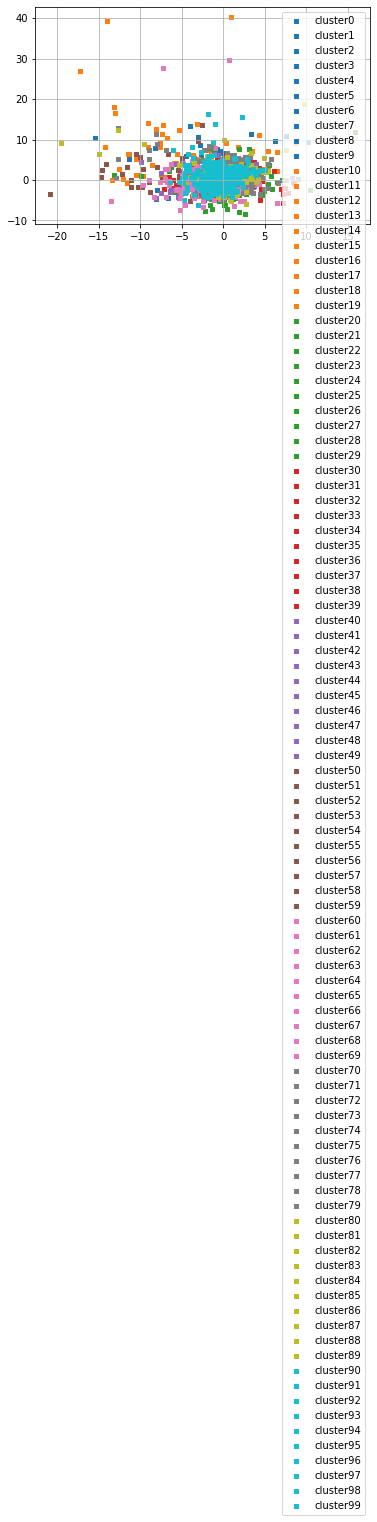

In [38]:
plot_clusters(all_features, y, dim=(0,1), dbscan=True)